EXPERIMENT 2
The error between the img and one GMM is "140.78029168802084"
The error between the img and ensemble of GMMs is "140.7941759024435"



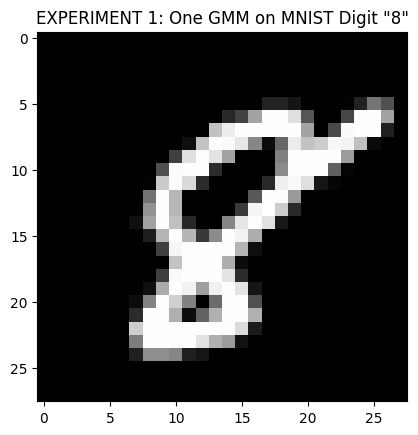

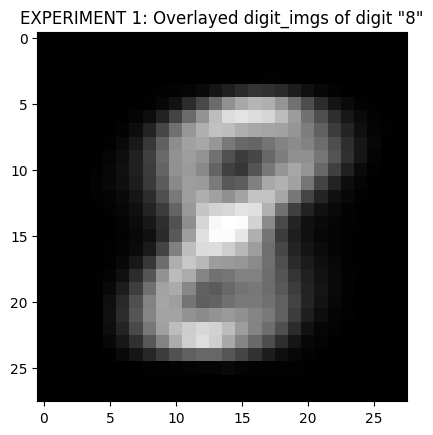

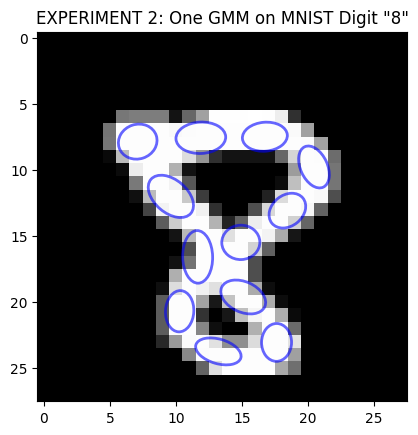

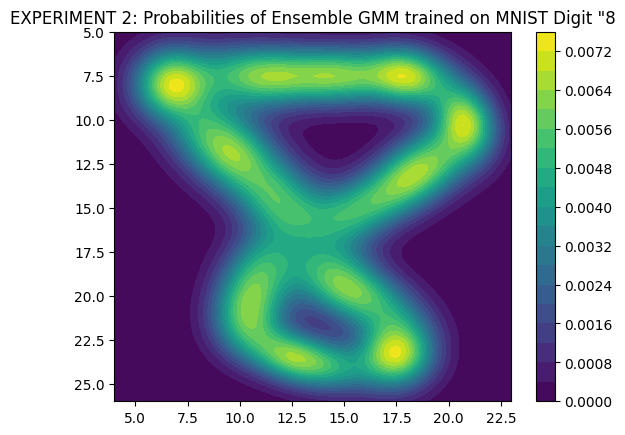

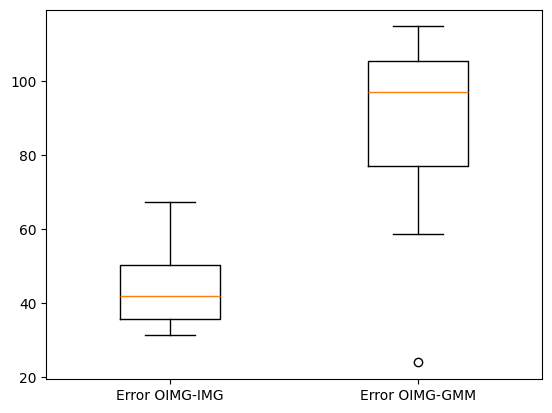

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
from matplotlib.patches import Ellipse

# creates XY_table out of img and only takes koordinates where the pixle value is bigger than 0
# the table consists of [x, y] where x is the column in the img array and y is the row in the img array (when seen in data viewer)
def create_XY_table(img):
    result = []
    for i in range(28):
        for j in range(28):
            if(img[i][j] > 0):
                result.append([j, i])
    return np.array(result)

# It creates an XY_table for all the imgs in the input array. Then it returns a Big table with all the Koordinates of all the arrays
def create_XY_table_for_imgs(imgs):
    if len(imgs) == 0:
        return np.array([])
    
    result = create_XY_table(imgs[0])
    for img in imgs[1:]:
        XY_table = create_XY_table(img)
        result = np.concatenate((result, XY_table), axis=0)
    return np.array(result)

def plot_gmm(gmm, ax, color='blue'):
    for i in range(gmm.n_components):
        mean = gmm.means_[i]
        cov = gmm.covariances_[i]

        v, w = np.linalg.eigh(cov)
        v = 2. * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])

        angle = np.degrees(np.arctan2(u[1], u[0]))
        ell = Ellipse(xy=mean, width=v[0], height=v[1], angle=angle, edgecolor=color, facecolor='none', lw=2)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.6)
        ax.add_patch(ell)

def sub_plot_gmm_probabilities_in_subplot(fig, ax, train_data, fitted_gmms):
    XY_grid, X_grid, Y_grid = generate_mesh_grid(train_data)
    log_likelihoods_grid = np.array([gmm.score_samples(XY_grid) for gmm in fitted_gmms])
    average_log_likelihood_grid = np.mean(log_likelihoods_grid, axis=0)
    averaged_probabilities_grid = np.exp(average_log_likelihood_grid).reshape(X_grid.shape)

    contour = ax.contourf(X_grid, Y_grid, averaged_probabilities_grid, levels=20, cmap='viridis')
    fig.colorbar(contour)
    #ax.scatter(train_data[:, 0], train_data[:, 1], s=40, marker='H', edgecolor='k', c='g')
    ax.invert_yaxis()
    return XY_grid

def generate_mesh_grid(train_data):
    x = np.linspace(train_data[:, 0].min() - 1, train_data[:, 0].max() + 1, 100)
    y = np.linspace(train_data[:, 1].max() + 1, train_data[:, 1].min() - 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    XY_grid = np.array([X_grid.ravel(), Y_grid.ravel()]).T
    return XY_grid, X_grid, Y_grid

# overlays all the digits in the input array over another and averages all the points in the digit 2D array
def overlay_mnistdigits(digit_imgs):
    result = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            total_pixle_value = 0
            for digit in digit_imgs:
                total_pixle_value = total_pixle_value + digit[i][j]
            result[i][j] = round(total_pixle_value/len(digit_imgs))
    return result

def convert_pixel_to_probabilities(digit_img):
    result = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            result[i][j] = digit_img[i][j]/255
    return result

### IMPORTANT XY_table must be from img
def compare_error_of_GMM_and_IMG(fitted_gmms, xy_table, img):
    img_with_probs = convert_pixel_to_probabilities(img)
    log_likelihoods = np.array([gmm.score_samples(xy_table) for gmm in fitted_gmms])
    average_log_likelihoods = np.mean(log_likelihoods, axis=0)
    predictions = np.exp(average_log_likelihoods)

    total_error = 0
    if len(xy_table) != len(predictions):
        raise ValueError(f"xy_table has to have the same length as the predictions array")
    for coord, prediction in zip(xy_table, predictions):
        #test = img_with_probs[coord[1]][coord[0]]
        total_error += (img_with_probs[coord[1]][coord[0]] - prediction)**2
    return total_error

def compare_error_of_IMG_and_IMG(img1, img2):
    img1_probs = convert_pixel_to_probabilities(img1)
    img2_probs = convert_pixel_to_probabilities(img2)

    total_error = 0
    for i in range(28):
        for j in range(28):
            total_error += (img1_probs[i][j] - img2_probs[i][j])**2
    return total_error

def experiment_1(single_digit_img, overlayed_digits, gmm_components):
    error_between_img_and_img = compare_error_of_IMG_and_IMG(overlayed_digits, single_digit_img)

    XY_table = create_XY_table(single_digit_img)
    gmm_01 = GaussianMixture(n_components=gmm_components, covariance_type='full')
    gmm_01.fit(XY_table)

    error_between_img_and_gmm = compare_error_of_GMM_and_IMG([gmm_01], XY_table, single_digit_img)
    return [error_between_img_and_img, error_between_img_and_gmm]

# Step 1: Load and preprocess MNIST data
(X_train, Y_train), (_, _) = mnist.load_data()  # X_train are the images of numbers represented in 2D arrays and Y_train is an array of numbers representing the lables of on the images

digit = 8
X_digit = X_train[Y_train == digit]
X_digit_img = X_digit[36]

### Experiment 1
overlayed_digits = overlay_mnistdigits(X_digit[:400])

#TEST
#[err_img_img, err_img_gmm] 
#eyyo = experiment_1(X_digit_img, overlayed_digits, 12)

result_1 = []
gmm_component_number = np.random.randint(7, 20, 20)
for img, component_number in zip(X_digit[20:40], gmm_component_number):
    result_1.append(experiment_1(img, overlayed_digits, 12))
result_1 = np.array(result_1)

### Experiment 2
digit_img_2 = X_digit[340]
XY_table_2 = create_XY_table(digit_img_2)

gmm2 = GaussianMixture(n_components=12, covariance_type='full')
gmm2.fit(XY_table_2)

gmm_array = [GaussianMixture(n_components=12, covariance_type='full') for _ in range(5)]

for one_gmm in gmm_array:
    one_gmm.fit(XY_table_2)

err_img_gmm = compare_error_of_GMM_and_IMG([gmm2], XY_table_2, digit_img_2)
err_img_gmm_2 = compare_error_of_GMM_and_IMG(gmm_array, XY_table_2, digit_img_2)

print("EXPERIMENT 2")
print(f'The error between the img and one GMM is "{err_img_gmm}"')
print(f'The error between the img and ensemble of GMMs is "{err_img_gmm_2}"')
print()


fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()

positions = [1,2]
data = [result_1[:, 0], result_1[:, 1]]
ax5.boxplot(data, positions=positions, widths=0.4)

ax5.set_xticks(positions) 
ax5.set_xticklabels(['Error OIMG-IMG', 'Error OIMG-GMM'])

plot_gmm(gmm2, ax3)

ax.imshow(X_digit_img, cmap='gray')
ax.set_title(f'EXPERIMENT 1: One GMM on MNIST Digit "{digit}"')
#sub_plot_gmm_probabilities_in_subplot(fig5, ax5, XY_table, [gmm_01])

ax2.imshow(overlayed_digits, cmap='gray')
ax2.set_title(f'EXPERIMENT 1: Overlayed digit_imgs of digit "{digit}"')

ax3.imshow(digit_img_2, cmap='gray')
ax3.set_title(f'EXPERIMENT 2: One GMM on MNIST Digit "{digit}"')

ax4.set_title(f'EXPERIMENT 2: Probabilities of Ensemble GMM trained on MNIST Digit "{digit}')
sub_plot_gmm_probabilities_in_subplot(fig4, ax4, XY_table_2, gmm_array)

plt.show()

## Experiment 1